<a href="https://colab.research.google.com/github/diegobnh/odroid_xu4/blob/master/Selecting_PerformanceCounters_ARM32.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Selecting Performance Monitoring Counter (pmc) on ARM Architecture


# Problem

---



One way to analyze the application's performance is to collect data from registers contained within the processor. Almost all CPU has a fixed number of registers which can be used to monitor application performance. These registers we will call Performance Monitoring Counter (PMC). The board analyzed in this experiment is called Odroid XU4. This board also has two CPU types: A7 (little core) and A15 (big core) with a maximum number of pmc per core of 4 and 6, respectively. Given a wide option of information that can be collected from the arm 32 architecture, only 4 for little and 6 for big can be collected at a time. The challenge is to know which information to collect that most contributes to explain the execution time.


# PMCs on Odroid

---

In little core only four pmc can be collected. In big core only six pmc can be collected. In total, 33 pmcs in little and 56 pmcs in big were analyzed as shown below:



*   Little core

inst_fetch_refill:0x01,inst_fetch_tlb_refill:0x02,data_rw_refill:0x03,data_rw_cache_access:0x04,data_rw_tlb_refill:0x05,data_read_exec:0x06,data_write_exec:0x07,ins_exec:0x08,excep_taken:0x09,excep_exec:0x0A,change_pc:0x0C,imed_branch_exec:0x0D,proc_return:0x0E,un_load_store:0x0F,br_pred:0x10,branches:0x12,data_mem_access:0x13,inst_cache_access:0x14,dcache_evic:0x15,l2d_cache_access:0x16,l2d_cache_refill:0x17,l2d_cache_write:0x18,bus_access:0x19,bus_cycle:0x1D,bus_access_read:0x60,bus_access_write:0x61,ext_mem_req:0xC0,no_cache_ext_mem_req:0xC1,enter_read_alloc_mode:0xC4,read_alloc_mode:0xC5,reserved:0xC6,data_w_stalls:0xC9,data_snooped:0xCA.
  

*   Big core

L1I_CACHE_REFILL:0x01,L1I_TLB_REFILL:0x02,L1D_CACHE_REFILL:0x03,L1D_CACHE_ACCESS:0x04,L1D_TLB_REFILL:0x05,INSTR_RETIRED:0x08,EXC_TAKEN:0x09,BR_MIS_PRED:0x10,BR_PRED:0x12,MEM_ACCESS:0x13,L1I_CACHE_ACCESS:0x14,L1D_CACHE_WB:0x15,L2D_CACHE_ACCESS:0x16,L2D_CACHE_REFILL:0x17,L2D_CACHE_WB:0x18,BUS_ACCESS:0x19,INST_SPEC:0x1B,BUS_CYCLES:0x1D,L1D_CACHE_LD:0x40,L1D_CACHE_ST:0x41,L1D_CACHE_REFILL_LD:0x42,L1D_CACHE_REFILL_ST:0x43,L1D_CACHE_WB_VICTIM:0x46,L1D_CACHE_WB_CLEAN:0x47,L1D_CACHE_INVAL:0x48,L1D_TLB_REFILL_LD:0X4C,L1D_TLB_REFILL_ST:0X4D,L2D_CACHE_LD:0x50,L2D_CACHE_ST:0x51,L2D_CACHE_REFILL_LD:0x52,L2D_CACHE_REFILL_ST:0x53,L2D_CACHE_WB_VICTIM:0x56,L2D_CACHE_INVAL:0x58,BUS_ACCESS_LD:0x60,BUS_ACCESS_ST:0x61,BUS_ACCESS_SHARED:0x62,BUS_ACCESS_NORMAL:0x64,MEM_ACCESS_LD:0x66,MEM_ACCESS_ST:0X67,UNALIGNED_LD_SPEC:0x68,UNALIGNED_ST_SPEC:0x69,UNALIGNED_LDST_SPEC:0x6A,LDREX_SPEC:0x6C,STREX_PASS_SPEC:0x6D,STREX_FAIL_SPEC:0x6E,LD_SPEC:0x70,ST_SPEC:0x70,LDST_SPEC:0x72,DP_SPEC:0x73,ASE_SPEC:0x74,VFP_SPEC:0x75,PC_WRITE_SPEC:0x76,BR_IMMED_SPEC:0x78,BR_RETURN_SPEC:0x79,BR_INDIRECT_SPEC:0x7A,DMB_SPEC:0x7E

# Applications

---



We chose bots for being a suite that makes use of the openmp. In addition, in bots you can see applications that have the best performance in the three configurations analyzed. Some suites is hard to find applications that perform better, for example, in the smallest configuration analyzed, in this case 4 little. These are the bot applications:


*   FFT: Computes a Fast Fourier Transformation.
*   Fib: Computes the nth fibonacci number using a recursive paralellization.
*   Floorplan: Computes the optimal placement of cells in a floorplan.
*   Health: Simulates a country health system.
*   NQueens: Finds solutions of the N Queens problem.
*   Sort: Uses a mixture of sorting algorithms to sort a vector.
*   SparseLU: Computes the LU factorization of a sparse matrix.
*   Strassen: Computes a matrix multiply with Strassen's method.



In [2]:
from google.colab import drive 
drive.mount('/mntDrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /mntDrive


# Explore the Data

---

After collecting all performance counters(33 in little and 56 in big), a dataset was created containing the average of each performance counter for each application.

Three different types of configurations were analyzed: 4b4l (all cores enabled), 4b (four big cores enabled) and 4l (four little cores enabled). Although the configuration space is small they are quite representative.

We model our problem as Multi Target Regression. So, the last 3 columns represent the speedup of time in 4l, 4b and 4b4l configuration. Speedup is calculated by dividing the runtime in one configuration by another. Values greater than 1 indicate that the configuration has a shorter execution time. The higher the value, the shorter the runtime. Values less than 1 indicate a longer execution time.

<img src="http://drive.google.com/uc?export=view&id=1xihH1i1vpl_EgrTMFZhb5A7vdbGhBmGC">

### Data collected from 4l config

In [3]:
import pandas as pd

path = "/mntDrive/My Drive/Doutorado/Feature Selection/data/bots/4l.csv"
df = pd.read_csv(path)

df.head(8)

,inst_fetch_refill:0x01,inst_fetch_tlb_refill:0x02,data_rw_refill:0x03,data_rw_cache_access:0x04,data_rw_tlb_refill:0x05,data_read_exec:0x06,data_write_exec:0x07,ins_exec:0x08,excep_taken:0x09,excep_exec:0x0A,change_pc:0x0C,imed_branch_exec:0x0D,proc_return:0x0E,un_load_store:0x0F,br_pred:0x10,branches:0x12,data_mem_access:0x13,inst_cache_access:0x14,dcache_evic:0x15,l2d_cache_access:0x16,l2d_cache_refill:0x17,l2d_cache_write:0x18,bus_access:0x19,bus_cycle:0x1D,bus_access_read:0x60,bus_access_write:0x61,ext_mem_req:0xC0,no_cache_ext_mem_req:0xC1,enter_read_alloc_mode:0xC4,read_alloc_mode:0xC5,reserved:0xC6,data_w_stalls:0xC9,data_snooped:0xCA,speedup4l,speedup4b,speedup4b4l
0,0.000716,5.393571e-05,0.005535,0.116889,0.000961,0.077897,0.023961,0.414214,0.000003,0.000003,0.040932,0.076223,0.001882,0.001490,0.006591,0.070949,0.117177,0.230069,0.002461,0.009404,0.001142,0.000211,0.009517,0.250001,0.006101,0.003653,0.008926,0.000806,4.285714e-08,0.007172,0.005148,0.009015,0.003078,1,0.974523,0.494156
1,0.003307,3.014286e-05,0.004371,0.167428,0.000428,0.100081,0.040155,0.432305,0.000412,0.000412,0.044850,0.081749,0.004362,0.001997,0.012226,0.071011,0.162272,0.293367,0.000214,0.009932,0.000019,0.000007,0.007948,0.250054,0.002359,0.006137,0.009259,0.003347,0.000000e+00,0.000640,0.004480,0.005356,0.005797,1,1.003448,0.433184
2,0.001089,2.623494e-06,0.003502,0.434471,0.000026,0.207505,0.182349,0.567200,0.000109,0.000109,0.028346,0.047574,0.002294,0.002905,0.006153,0.042736,0.427060,0.338646,0.003348,0.012155,0.000263,0.003083,0.015938,0.249994,0.002264,0.016037,0.012965,0.001129,1.452771e-04,0.589795,0.001654,0.150489,0.000441,1,2.077785,1.289714
3,0.000297,7.391304e-06,0.004481,0.093421,0.000073,0.055662,0.025300,0.277840,0.000004,0.000004,0.025847,0.041273,0.001908,0.000405,0.003050,0.037999,0.093591,0.160829,0.002997,0.007788,0.002233,0.002045,0.019211,0.250000,0.010189,0.009032,0.007823,0.000355,0.000000e+00,0.006861,0.001531,0.003657,0.001486,1,1.251237,0.789967
4,0.001759,7.884211e-06,0.004174,0.170126,0.000161,0.110293,0.037861,0.622169,0.000203,0.000203,0.061406,0.143258,0.003450,0.001354,0.013467,0.132634,0.170173,0.373689,0.000135,0.006088,0.000010,0.000006,0.005310,0.250011,0.001839,0.003483,0.005953,0.001526,0.000000e+00,0.000270,0.003317,0.005381,0.003992,1,0.932477,0.507174
5,0.000322,3.658960e-06,0.004420,0.042430,0.001671,0.019601,0.018367,0.220219,0.000008,0.000008,0.029917,0.039931,0.003525,0.000142,0.007076,0.034563,0.042848,0.140082,0.004413,0.009281,0.003388,0.002044,0.022509,0.250000,0.013898,0.008870,0.009458,0.000381,9.653179e-07,0.030250,0.011556,0.012683,0.000019,1,1.738158,1.869762
6,0.000075,9.128440e-07,0.003437,0.246938,0.000006,0.165763,0.081080,0.580321,0.000001,0.000001,0.081399,0.082811,0.000050,0.000028,0.000979,0.082670,0.246845,0.260306,0.003442,0.007015,0.000144,0.000059,0.000818,0.250000,0.000583,0.000238,0.007018,0.000128,0.000000e+00,0.003608,0.002509,0.000121,0.000004,1,2.834962,3.620718
7,0.000164,3.287823e-06,0.005418,0.159371,0.002423,0.132459,0.024853,0.331228,0.000009,0.000009,0.014868,0.018477,0.000864,0.000822,0.000728,0.016774,0.158802,0.177296,0.005316,0.010904,0.001803,0.000914,0.011764,0.250001,0.008026,0.003728,0.011126,0.000232,4.944649e-07,0.132542,0.007970,0.009611,0.000004,1,1.986178,2.473063


In [4]:
print(df.describe())
#select_features_df = df[select_features]


       inst_fetch_refill:0x01  ...  speedup4b4l
count                8.000000  ...     8.000000
mean                 0.000966  ...     1.434717
std                  0.001101  ...     1.148341
min                  0.000075  ...     0.433184
25%                  0.000264  ...     0.503920
50%                  0.000519  ...     1.039840
75%                  0.001256  ...     2.020587
max                  0.003307  ...     3.620718

[8 rows x 36 columns]


### Data collected from 4b config


In [5]:
path = "/mntDrive/My Drive/Doutorado/Feature Selection/data/bots/4b.csv"
df = pd.read_csv(path)

df.head(8)

,L1I_CACHE_REFILL:0x01,L1I_TLB_REFILL:0x02,L1D_CACHE_REFILL:0x03,L1D_CACHE_ACCESS:0x04,L1D_TLB_REFILL:0x05,INSTR_RETIRED:0x08,EXC_TAKEN:0x09,BR_MIS_PRED:0x10,BR_PRED:0x12,MEM_ACCESS:0x13,L1I_CACHE_ACCESS:0x14,L1D_CACHE_WB:0x15,L2D_CACHE_ACCESS:0x16,L2D_CACHE_REFILL:0x17,L2D_CACHE_WB:0x18,BUS_ACCESS:0x19,INST_SPEC:0x1B,BUS_CYCLES:0x1D,L1D_CACHE_LD:0x40,L1D_CACHE_ST:0x41,L1D_CACHE_REFILL_LD:0x42,L1D_CACHE_REFILL_ST:0x43,L1D_CACHE_WB_VICTIM:0x46,L1D_CACHE_WB_CLEAN:0x47,L1D_CACHE_INVAL:0x48,L1D_TLB_REFILL_LD:0X4C,L1D_TLB_REFILL_ST:0X4D,L2D_CACHE_LD:0x50,L2D_CACHE_ST:0x51,L2D_CACHE_REFILL_LD:0x52,L2D_CACHE_REFILL_ST:0x53,L2D_CACHE_WB_VICTIM:0x56,L2D_CACHE_INVAL:0x58,BUS_ACCESS_LD:0x60,BUS_ACCESS_ST:0x61,BUS_ACCESS_SHARED:0x62,BUS_ACCESS_NORMAL:0x64,MEM_ACCESS_LD:0x66,MEM_ACCESS_ST:0X67,UNALIGNED_LD_SPEC:0x68,UNALIGNED_ST_SPEC:0x69,UNALIGNED_LDST_SPEC:0x6A,LDREX_SPEC:0x6C,STREX_PASS_SPEC:0x6D,STREX_FAIL_SPEC:0x6E,LD_SPEC:0x70,ST_SPEC:0x70,LDST_SPEC:0x72,DP_SPEC:0x73,ASE_SPEC:0x74,VFP_SPEC:0x75,PC_WRITE_SPEC:0x76,BR_IMMED_SPEC:0x78,BR_RETURN_SPEC:0x79,BR_INDIRECT_SPEC:0x7A,DMB_SPEC:0x7E,speedup4l,speedup4b,speedup4b4l
0,0.000967,0.000020,0.006457,0.180469,0.001909,1.049162,0.000002,0.003541,0.232298,0.181512,0.121381,0.002362,0.014382,0.000732,1.168278e-04,0.003408,1.167622,0.199992,0.154636,0.026783,0.004001,0.002229,0.000357,1.954609e-03,3.063404e-03,0.001572,0.000320,0.009117,0.005174,0.000622,1.076291e-04,1.182980e-04,1.006623e-06,0.002930,0.000485,0.003415,0.003456,0.154915,0.026531,0.000387,0.000483,0.000869,0.002246,0.000890,4.377351e-04,0.169820,0.024258,0.190963,0.722046,0.000001,1.159464e-02,0.232842,0.230077,0.001622,0.002769,0.001620,1.026143,1,0.507074
1,0.001339,0.000032,0.006609,0.195773,0.000152,0.824712,0.000278,0.003916,0.194102,0.188590,0.145057,0.002792,0.015873,0.000011,2.538462e-06,0.000053,0.923499,0.199840,0.151092,0.045178,0.003251,0.002590,0.000138,1.916811e-03,3.260059e-03,0.000145,0.000007,0.009214,0.006783,0.000009,1.775148e-08,5.976331e-07,1.076923e-06,0.000009,0.000002,0.000011,0.000053,0.145433,0.046953,0.000863,0.000851,0.001714,0.002749,0.001824,2.471657e-04,0.160038,0.043988,0.199572,0.531840,0.000004,1.301775e-07,0.176333,0.169086,0.004177,0.007343,0.001578,0.996564,1,0.431696
2,0.001038,0.000033,0.008039,0.734961,0.000776,1.027466,0.000165,0.003599,0.095682,0.715828,0.292630,0.003836,0.032021,0.000015,5.283951e-06,0.000275,1.112027,0.199980,0.378611,0.340935,0.005892,0.002634,0.002946,7.186481e-04,8.231049e-04,0.000765,0.000107,0.009512,0.021465,0.000013,9.882716e-06,4.709259e-05,1.104938e-06,0.000646,0.000267,0.000914,0.000356,0.385936,0.347458,0.002805,0.000813,0.003619,0.001654,0.001528,1.925309e-05,0.383779,0.327591,0.709013,0.272425,0.000004,1.001049e-03,0.097997,0.089346,0.004305,0.008493,0.001656,0.481282,1,0.620715
3,0.000134,0.000014,0.005855,0.117148,0.000275,0.488417,0.000002,0.001294,0.093911,0.116356,0.078326,0.003762,0.013543,0.002115,1.956246e-03,0.016280,0.530124,0.200005,0.085776,0.031101,0.003947,0.001660,0.002331,1.422860e-03,1.673772e-03,0.000262,0.000021,0.008003,0.005433,0.002099,1.422807e-05,1.958211e-03,9.473684e-07,0.008462,0.007833,0.016294,0.016405,0.086287,0.031352,0.000541,0.000552,0.001093,0.001427,0.001082,7.505263e-05,0.090426,0.026878,0.115031,0.304605,0.000001,9.156018e-03,0.094109,0.091147,0.001875,0.002955,0.001430,0.799209,1,0.631349
4,0.001095,0.000015,0.005963,0.208453,0.000161,1.104104,0.000150,0.006148,0.261705,0.208724,0.190619,0.002102,0.011775,0.000004,9.633028e-07,0.000021,1.286617,0.202377,0.169423,0.039128,0.003502,0.002372,0.000241,1.762413e-03,3.000890e-03,0.000144,0.000024,0.007057,0.004565,0.000004,3.669725e-08,8.990826e-07,1.000000e-06,0.000015,0.000004,0.000020,0.000019,0.168636,0.039082,0.000468,0.000544,0.001012,0.002465,0.001293,3.448991e-04,0.188723,0.037926,0.223338,0.766204,0.000002,0.000000e+00,0.262549,0.256999,0.003112,0.005365,0.001952,1.072412,1,0.543900
5,0.000163,0.000040,0.003056,0.067829,0.002305,0.308422,0.000012,0.008274,0.06808

In [6]:
print(df.describe())

       L1I_CACHE_REFILL:0x01  L1I_TLB_REFILL:0x02  ...  speedup4b  speedup4b4l
count               8.000000             8.000000  ...        8.0     8.000000
mean                0.000613             0.000024  ...        1.0     0.791594
std                 0.000542             0.000010  ...        0.0     0.348243
min                 0.000045             0.000012  ...        1.0     0.431696
25%                 0.000131             0.000015  ...        1.0     0.534694
50%                 0.000565             0.000024  ...        1.0     0.626032
75%                 0.001052             0.000032  ...        1.0     1.118070
max                 0.001339             0.000040  ...        1.0     1.277166

[8 rows x 59 columns]


### Data collected from 4b4l config


In [7]:
path = "/mntDrive/My Drive/Doutorado/Feature Selection/data/bots/4b4l.csv"
df = pd.read_csv(path)

df.head(8)


,inst_fetch_refill:0x01,inst_fetch_tlb_refill:0x02,data_rw_refill:0x03,data_rw_cache_access:0x04,data_rw_tlb_refill:0x05,data_read_exec:0x06,data_write_exec:0x07,ins_exec:0x08,excep_taken:0x09,excep_exec:0x0A,change_pc:0x0C,imed_branch_exec:0x0D,proc_return:0x0E,un_load_store:0x0F,br_pred:0x10,branches:0x12,data_mem_access:0x13,inst_cache_access:0x14,dcache_evic:0x15,l2d_cache_access:0x16,l2d_cache_refill:0x17,l2d_cache_write:0x18,bus_access:0x19,bus_cycle:0x1D,bus_access_read:0x60,bus_access_write:0x61,ext_mem_req:0xC0,no_cache_ext_mem_req:0xC1,enter_read_alloc_mode:0xC4,read_alloc_mode:0xC5,reserved:0xC6,data_w_stalls:0xC9,data_snooped:0xCA,L1I_CACHE_REFILL:0x01,L1I_TLB_REFILL:0x02,L1D_CACHE_REFILL:0x03,L1D_CACHE_ACCESS:0x04,L1D_TLB_REFILL:0x05,INSTR_RETIRED:0x08,EXC_TAKEN:0x09,...,L1D_CACHE_ST:0x41,L1D_CACHE_REFILL_LD:0x42,L1D_CACHE_REFILL_ST:0x43,L1D_CACHE_WB_VICTIM:0x46,L1D_CACHE_WB_CLEAN:0x47,L1D_CACHE_INVAL:0x48,L1D_TLB_REFILL_LD:0X4C,L1D_TLB_REFILL_ST:0X4D,L2D_CACHE_LD:0x50,L2D_CACHE_ST:0x51,L2D_CACHE_REFILL_LD:0x52,L2D_CACHE_REFILL_ST:0x53,L2D_CACHE_WB_VICTIM:0x56,L2D_CACHE_INVAL:0x58,BUS_ACCESS_LD:0x60,BUS_ACCESS_ST:0x61,BUS_ACCESS_SHARED:0x62,BUS_ACCESS_NORMAL:0x64,MEM_ACCESS_LD:0x66,MEM_ACCESS_ST:0X67,UNALIGNED_LD_SPEC:0x68,UNALIGNED_ST_SPEC:0x69,UNALIGNED_LDST_SPEC:0x6A,LDREX_SPEC:0x6C,STREX_PASS_SPEC:0x6D,STREX_FAIL_SPEC:0x6E,LD_SPEC:0x70,ST_SPEC:0x70,LDST_SPEC:0x72,DP_SPEC:0x73,ASE_SPEC:0x74,VFP_SPEC:0x75,PC_WRITE_SPEC:0x76,BR_IMMED_SPEC:0x78,BR_RETURN_SPEC:0x79,BR_INDIRECT_SPEC:0x7A,DMB_SPEC:0x7E,speedup4l,speedup4b,speedup4b4l
0,0.000446,2.038194e-05,0.002690,0.057081,0.000381,0.050227,0.007879,0.351455,1.476389e-05,1.476389e-05,0.035848,0.069540,0.000547,0.000408,0.002366,0.069099,0.059526,0.156101,0.000770,0.003988,0.000629,4.652083e-05,0.003934,0.250001,0.003333,0.000622,0.003978,0.000393,0.000000e+00,0.000091,0.001905,0.001395,0.001683,0.000186,0.000017,0.002348,0.102874,0.000477,0.767597,2.837102e-05,...,0.007104,0.001759,0.000624,0.000094,4.688834e-04,1.519608e-03,0.000334,0.000072,0.003019,0.001075,0.000354,0.000297,3.093993e-05,0.001162,0.002629,0.000140,0.002770,0.002767,0.094335,0.007237,0.000097,0.000124,0.000221,0.000859,0.000264,2.797703e-04,0.105192,0.006221,0.110139,0.536486,0.000001,2.950276e-03,0.175072,0.174184,0.000536,0.000828,0.000551,2.023654,1.972097,1
1,0.000274,4.864362e-06,0.002227,0.033157,0.000041,0.030328,0.002766,0.229980,1.773404e-05,1.773404e-05,0.024738,0.047610,0.000498,0.000213,0.002156,0.050256,0.043609,0.117296,0.000010,0.002814,0.000714,6.598404e-06,0.005218,0.250007,0.004119,0.000522,0.003285,0.000772,0.000000e+00,0.000021,0.001494,0.004685,0.000007,0.000560,0.000024,0.003187,0.089149,0.000067,0.521479,1.984545e-04,...,0.010447,0.001968,0.001057,0.000027,8.700771e-04,2.011747e-03,0.000030,0.000003,0.003113,0.001665,0.000144,0.000510,3.691460e-07,0.000621,0.002662,0.000002,0.002664,0.003012,0.068851,0.011956,0.000203,0.000209,0.000412,0.001095,0.000452,2.034876e-04,0.093065,0.012543,0.103849,0.470890,0.000003,0.000000e+00,0.154513,0.152957,0.000931,0.002192,0.000603,2.308486,2.316445,1
2,0.001076,6.217241e-06,0.003365,0.192554,0.000049,0.113069,0.083239,0.414258,7.145172e-05,7.145172e-05,0.030404,0.056606,0.001103,0.000842,0.003908,0.052717,0.201104,0.219681,0.002018,0.007769,0.000592,1.699717e-03,0.011553,0.249997,0.003654,0.007010,0.007941,0.001174,9.632069e-05,0.514919,0.001448,0.073702,0.001227,0.000457,0.000020,0.004612,0.283519,0.000371,0.801641,7.025275e-05,...,0.094045,0.002817,0.000923,0.000777,3.265861e-04,1.482553e-03,0.000240,0.000052,0.004772,0.006541,0.000908,0.000494,6.380952e-06,0.001381,0.004524,0.000069,0.004593,0.004638,0.178160,0.101763,0.000814,0.000281,0.001096,0.000834,0.000319,2.260476e-04,0.181060,0.082342,0.262215,0.554187,0.000004,2.541868e-04,0.183522,0.181205,0.001172,0.002855,0.000762,0.775366,1.611044,1
3,0.000246,2.066304e-05,0.002637,0.066409,0.000080,0.051935,0.009662,0.373984,2.902174e-06,2.902174e-06,0.039820,0.075097,0.000743,0.000150,0

In [8]:
print(df.describe())

       inst_fetch_refill:0x01  ...  speedup4b4l
count                8.000000  ...          8.0
mean                 0.000464  ...          1.0
std                  0.000379  ...          0.0
min                  0.000048  ...          1.0
25%                  0.000198  ...          1.0
50%                  0.000360  ...          1.0
75%                  0.000764  ...          1.0
max                  0.001076  ...          1.0

[8 rows x 92 columns]


### Global variables

In [0]:
'''
RFR = RANDOM FOREST REGRESSOR
DTR = DECISION TREE REGRESSOR
RFE = RECURSIVE FEATURE ELIMINATION
RFI = RECURSIVE FEATURE INSERT
'''

FILTER_METHOD, FEATURE_IMPORTANCE_DTR, FEATURE_IMPORTANCE_RFR, RFE_LINEAR, RFE_DTR, RFE_RFR, RFI_LINEAR, RFI_DTR, RFI_RFR = range(9)

PERFORMANCE_TARGET, POWER_TARGET = range(2)    
    
FOUR_LITTLE, FOUR_BIG, FOUR_LITTLE_FOUR_BIG = range(3)


# Filter Method


---


Two approaches are used in this work to decide which feature better explain the execution time: Filter and Wrapper method. The main difference between them is that the first does not use a model, while the second makes use of model. The choice of methods may impact the quality of the model. For example, Wrapper methods are more likely to incur overfitting. 

Some examples of some filter methods are the Chi squared test, information gain, ANOVA, correlation coefficient and others. Which method to choose will depend on the feature variable type and the target variable. We are using Pearson's Correlations because our dataset. The pearson's correlation is an correlation coefficient that quantify linear dependence between two continuous variable and this approach was used here.

In [0]:
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import operator



def get_features_filter(file_path, target,g_perc_correc):
    
  df = pd.read_csv(file_path)

  correlation_matrix = df.corr()
  
  cor_target = abs(correlation_matrix[target])     
  #relevant_features = cor_target[cor_target >= g_perc_correc]#return um object serie. When g_perc_correc is zero still stay away some pmcs
  relevant_features = cor_target

  values = relevant_features.values #get values from object    
  features_selected = relevant_features.keys() #get labels from object 
   
  dictionary = dict(zip(features_selected, values))
  
  dictionary.pop('speedup4l',None)
  dictionary.pop('speedup4b',None)
  dictionary.pop('speedup4b4l',None)
  dictionary.pop('power',None)  

  return dictionary

def plot_correlation_between_features_selected(file_path,selected_feature,number_features):

  df = pd.read_csv(file_path)
  
  new_data = df[selected_feature].corr().abs()
  
  #new_data = new_data[new_data < 0.8]
  
  mask = np.zeros_like(new_data)
  mask[np.triu_indices_from(mask)] = True

  plt.rcParams["figure.figsize"] = (number_features,number_features/2)
      
  sns.heatmap(new_data, mask=mask, cmap=plt.cm.Blues, linewidth = .5,annot=True, fmt=".2f")
  plt.subplots_adjust(bottom=0.3,left=0.25)
  plt.xticks(rotation=90)
  plt.show()

# Wrapper Method

Wrapper-based methods use models to decide which pmcs to select.

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

df = 0
df_X = 0
df_Y = 0
r2_before = 0
r2_after = 0
cols = 0
df_order_list = 0

def calc_feature_importance(file_path, type_of_model, type_of_target):
  global df, df_X, df_Y, r2_before, r2_after, cols, df_order_list

  if type_of_target == PERFORMANCE_TARGET:
     num_target_predict = 3 
  elif type_of_target == POWER_TARGET:
     num_target_predict = 1 
  

  df = pd.read_csv(file_path)
  df_X = df.iloc[:, 0:(len(df.columns) - num_target_predict)]
  df_Y = df.iloc[:, len(df.columns) - num_target_predict: len(df.columns)]  
  
  X = df_X.values 
  Y = df_Y.values
  
  if type_of_model == FEATURE_IMPORTANCE_DTR:
     regr_rf = DecisionTreeRegressor(random_state=37)
  elif type_of_model == FEATURE_IMPORTANCE_RFR:
     regr_rf = RandomForestRegressor(n_estimators=100, max_depth=30,random_state=2)
  else:
     print("Error in type of model !!!")

  #regr_rf.fit(X, Y.ravel())
  regr_rf.fit(X, Y.ravel())
  y_rf = regr_rf.predict(X)
  r2_before = float("{0:.2f}".format(r2_score(Y.ravel(), y_rf)))

  #Mapping each importance value to feature and after sort.
  result=[]
  for feature in zip(df.columns, regr_rf.feature_importances_):
      result.append(tuple(feature))

  order_list = sorted(result,key=operator.itemgetter(1), reverse=True)
  #if(len(order_list) > 50):#remove features over 50, because the size plot
  #   order_list = order_list[:len(order_list)-(len(order_list)-50)]


  #Convert dictionary to dataframe
  df_order_list = pd.DataFrame(order_list)     
  feat_imp = regr_rf.feature_importances_ 
  
  cols = df_X.columns[feat_imp >= 0.0]  
   
  #Evaluate the model now only with the selected fetures.
  
  if type_of_model == FEATURE_IMPORTANCE_DTR:
     est_imp = DecisionTreeRegressor(random_state=37)
  elif type_of_model == FEATURE_IMPORTANCE_RFR:
     est_imp = RandomForestRegressor(n_estimators=100, max_depth=30,random_state=2)  
    
  #est_imp.fit(df_X[cols].values, df_Y.values.ravel())
  est_imp.fit(df_X[cols].values, df_Y.values.ravel())
  y_rf = est_imp.predict(df_X[cols].values)
  r2_after = float("{0:.2f}".format(r2_score(df_Y.values.ravel(), y_rf.ravel())))
  
def plot_features_importance(file_path, type_of_model, type_of_target):
  
  calc_feature_importance(file_path, type_of_model, type_of_target)
  #Graph
  font = {'family' : 'sans-serif', 'size': 12}
  plt.rc('font', **font)

  title_string = "Feature Importance" + "\n All Select Columns(Total=" + str(len(df_X.columns)) + "), R² =" + str(r2_before) +  "\n Nº Select Columns = " + str(len(cols)) + ", R²= " + str(r2_after)
  plt.figure(figsize=(25, 20))
  sns.set_style("whitegrid")
  ax = sns.barplot(df_order_list[1],df_order_list[0], palette="Blues_d")

  ax.set_title(title_string,fontsize= 20) 
  ax.set_xlabel('Importance',fontsize = 20) 
  ax.set_ylabel('Counters', fontsize = 20)
  
  plt.show()

def select_feature_importance(file_path, type_of_model, type_of_target):

  calc_feature_importance(file_path,type_of_model,type_of_target)
  dictionary = dict(zip(df_order_list[0],df_order_list[1]))  
  return dictionary

In [0]:
import numpy as np 
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE


def select_feature_RFE(file_path, config, type_of_model,type_of_target):
   if type_of_target == PERFORMANCE_TARGET:
     num_target_predict = 3 
   elif type_of_target == POWER_TARGET:
     num_target_predict = 1 
  

   df = pd.read_csv(file_path)
   df_X = df.iloc[:, 0:(len(df.columns) - num_target_predict)]
   df_Y = df.iloc[:, len(df.columns) - num_target_predict: len(df.columns)]  
  
   X = df_X.values 
   Y = df_Y.values
   

   if type_of_model == RFE_LINEAR:
       if type_of_target == PERFORMANCE_TARGET:
              print("O modelo linear não suporta multitarget!!!")
       else:
              model = LinearRegression()
       model = LinearRegression()
   elif type_of_model == RFE_DTR:
       model = DecisionTreeRegressor(random_state=37)             
   elif type_of_model == RFE_RFR:
       model = RandomForestRegressor(n_estimators=100, max_depth=30,random_state=2)
          
            
   if config == FOUR_LITTLE:
      n_features=4
   elif config == FOUR_BIG:
      n_features=6
   elif config == FOUR_LITTLE_FOUR_BIG:
      n_features=10
            
   rfe = RFE(model, n_features_to_select=n_features)
   rfe = rfe.fit(X,Y.ravel())
   y_rf = rfe.predict(X)
      
   
   
   pmus_select = list(df_X.columns[rfe.support_])
   for i in range(len(pmus_select)):
     print(pmus_select[i])
   print("\nR2_score:",r2_score(Y, y_rf)) 
    
   

def select_feature_RFI(file_path, config, type_of_model,type_of_target):

    df = pd.read_csv(file_path)
    array = df.values
  
    index_pmcs_select = []

    if config==FOUR_LITTLE:

            index_ipc_little = 7

            best_score = -1
            best_index = -1
            select_pmus = array[:,[index_ipc_little]] #Um dos 4 pmcs é o ipc
            index_pmcs_select.append(index_ipc_little) 

            for pmus_select in range(4):
                #print("Select pmu:", pmus_select)
                for i in range (len(df.columns)-1): 
             
                    if type_of_model == RFI_LINEAR:
                        if type_of_target == PERFORMANCE_TARGET:
                           print("O modelo linear não suporta multitarget!!!")
                        else:
                           model = LinearRegression()
                    elif type_of_model == RFI_DTR:
                        model = DecisionTreeRegressor(random_state=37)             
                    elif type_of_model == RFI_RFR:
                        model = RandomForestRegressor(n_estimators=100, max_depth=30,random_state=2)
                    

                    if i not in index_pmcs_select:
                    
                       column = array[:,[i]] #seleciona a coluna a ser testada            
                       X = np.concatenate((select_pmus, column), axis=1) #concatena com os atuais pmus
                       Y = array[:, (len(df.columns) - 1)] #LITTLE                                                           
                                   
                       model.fit(X, Y)

                       current_score = model.score(X,Y)              
                 
                       if current_score > best_score:
                          best_score = current_score
                          best_index = i
                          #input("Pressione <enter> para continuar")

                if best_index not in index_pmcs_select:      
                   print("Inter:",pmus_select, " PMU selected:",df.columns.values[best_index]," Score:",best_score)
                   index_pmcs_select.append(best_index)
                   column = array[:,[best_index]] 
                   select_pmus = np.concatenate((select_pmus, column), axis=1) 


    elif config==FOUR_BIG:

            index_ipc_big = 5

            best_score = -1
            best_index = 1
            select_pmus = array[:,[index_ipc_big]] #Um dos 6 pmcs é o ipc
            index_pmcs_select.append(index_ipc_big) 

            for pmus_select in range(6):
                for i in range (len(df.columns)-1):  

                   
                    if type_of_model == RFI_LINEAR:
                        if type_of_target == PERFORMANCE_TARGET:
                           print("O modelo linear não suporta multitarget!!!")
                        else:
                           model = LinearRegression()
                    elif type_of_model == RFI_DTR:
                        model = DecisionTreeRegressor(random_state=37)             
                    elif type_of_model == RFI_RFR:
                        model = RandomForestRegressor(n_estimators=100, max_depth=30,random_state=2)
                    

                 
                    if i not in index_pmcs_select:
                    
                       column = array[:,[i]] #seleciona a coluna a ser testada            
                       X = np.concatenate((select_pmus, column), axis=1) #concatena com os atuais pmus
                       Y = array[:, (len(df.columns) - 1)]
                       
                       model.fit(X, Y)

                       current_score = model.score(X,Y)              
                 
                       if current_score > best_score:
                          best_score = current_score
                          best_index = i
                          #input("Pressione <enter> para continuar")
                 
                if best_index not in index_pmcs_select:   
                   print("Iter:",pmus_select, " PMU selected:",df.columns.values[best_index]," Score:",best_score)
                   index_pmcs_select.append(best_index)
                   column = array[:,[best_index]] 
                   select_pmus = np.concatenate((select_pmus, column), axis=1) 

            #print(index_pmcs_select)

    elif config==FOUR_LITTLE_FOUR_BIG:

            index_ipc_little = 7
            index_ipc_big = 38

            best_score = -1
            best_index = 1
            select_pmus = array[:,[index_ipc_little]] #Um dos 6 pmcs é o ipc
            index_pmcs_select.append(index_ipc_little) 
            select_pmus = array[:,[index_ipc_big]] #Um dos 6 pmcs é o ipc
            index_pmcs_select.append(index_ipc_big) 

            for pmus_select in range(10):
                for i in range (len(df.columns)-1):  

                    
                    if type_of_model == RFI_LINEAR:
                        model = LinearRegression()
                    elif type_of_model == RFI_DTR:
                        model = DecisionTreeRegressor(random_state=37)             
                    elif type_of_model == RFI_RFR:
                        MODEL = RandomForestRegressor(n_estimators=100, max_depth=30,random_state=2)
                    

                 
                    if i not in index_pmcs_select:
                    
                       column = array[:,[i]] #seleciona a coluna a ser testada            
                       X = np.concatenate((select_pmus, column), axis=1) #concatena com os atuais pmus
                       Y = array[:, (len(df.columns) - 1)]
                    
                       model.fit(X, Y)

                       current_score = model.score(X,Y)              
                 
                       if current_score > best_score:
                          best_score = current_score
                          best_index = i
                          #input("Pressione <enter> para continuar")
                 
                if best_index not in index_pmcs_select:   
                   print("Iter:",pmus_select," index:",best_index, " PMU selected:",df.columns.values[best_index]," Score:",best_score)
                   index_pmcs_select.append(best_index)
                   column = array[:,[best_index]] 
                   select_pmus = np.concatenate((select_pmus, column), axis=1) 



# Hierarchical Cluster Analyses(HCA)

Basically, HCS groups similar objects into groups called clusters. The endpoint is a set of clusters, where each cluster is distinct from each other cluster, and the objects within each cluster are broadly similar to each other. This technique is important to eliminate redundancies in building our model.

In [0]:
import scipy.cluster.hierarchy as shc
from enum import Enum
from scipy.spatial.distance import pdist


def drop_constant_column(dataframe):
    """
    Drops constant value columns of pandas dataframe.
    """
    return dataframe.loc[:, (dataframe != dataframe.iloc[0]).any()]

#this function can just plot hca or return correlation of features per cluster 
def create_hca(path_file, index_config):
    df = pd.read_csv(path_file)

    if index_config == 0: 
       cluster_df = df.iloc[:,0:33]
       plt.figure(figsize=(15, 9))
    elif index_config == 1:
       cluster_df = df.iloc[:,0:56]
       plt.figure(figsize=(15, 12))
    else:
       cluster_df = df.iloc[:,0:89]
       plt.figure(figsize=(23, 18))

    new_cluster_df = drop_constant_column(cluster_df)
    corr = 1 - new_cluster_df.corr().abs()  
    corr_condensed = shc.distance.squareform(corr) # convert to condensed

    z = shc.linkage(corr_condensed, method='average')
    dendrogram = shc.dendrogram(z,orientation="right",labels=corr.columns,leaf_rotation=0,leaf_font_size=10) #if orientation right, change rotation to 0

    plt.show()

def get_features_per_cluster(path_file, index_config, number_of_clusters, type_of_model, type_of_target):

    df = pd.read_csv(path_file)

    if index_config == 0: 
       cluster_df = df.iloc[:,0:33]  
    elif index_config == 1:
       cluster_df = df.iloc[:,0:56]    
    else:
       cluster_df = df.iloc[:,0:89]

    new_cluster_df = drop_constant_column(cluster_df)
    corr = 1 - new_cluster_df.corr().abs()  
    corr_condensed = shc.distance.squareform(corr) # convert to condensed

    z = shc.linkage(corr_condensed, method='average')

    tree = shc.cut_tree(z, n_clusters = number_of_clusters)

    feat_per_cluster = [[] for i in range(0, number_of_clusters)]#create list of features for each cluster
    feat_correlation = [[] for i in range(0, number_of_clusters)]

    for i in range(len(new_cluster_df.columns)):    
       cluster_id = tree[i][0]
       feat_per_cluster[cluster_id].append(df.columns[i])#add elements to its clusters

    if type_of_model == FILTER_METHOD:
       if type_of_target == POWER_TARGET:
          target = "power"
       elif index_config == 0:
          target = "speedup4b"
       elif index_config == 1:
          target = "speedup4l"
       elif index_config == 2:
          target = "speedup4b"       
       dictionary = get_features_filter(path_file,target,0.0)
    #PRECISO AJUSTAR DE MODO QUE TODOS CONSIGAM RETORNAR UM DICIONÁRIO ...PRECISO VER ISSO
    if type_of_model == FEATURE_IMPORTANCE_DTR :
       dictionary = select_feature_importance(path_file, type_of_model,type_of_target)
    else:
       print("Erro type of model!! ",type_of_model)
       dictionary = {}

    if index_config == FOUR_LITTLE:
        if (len(dictionary) != 33):
            print("Error! Dictionary 4l should have 33 but has only:",len(dictionary))
    elif indexconfig == FOUR_BIG:
        if (len(dictionary) != 56):
            print("Error! Dictionary 4b should have 56 but has only:",len(dictionary))
    elif index_config == FOUR_LITTLE_FOUR_BIG:
        if (len(dictionary) != 89):
            print("Error! Dictionary should have 89 but has only:",len(dictionary))
    
    for i in range(number_of_clusters):
      for j in range(len(feat_per_cluster[i])):     
         feat_correlation[i].append(dictionary.get(feat_per_cluster[i][j]))  


    #This part correct this problem: TypeError: '>' not supported between instances of 'float' and 'NoneType'
    for i in range(number_of_clusters):
       for j in range(len(feat_per_cluster[i])-1):
           if feat_correlation[i][j] == None:               
              feat_correlation[i].pop(j)
              feat_per_cluster[i].pop(j)

    #features_correlation_per_cluster = [[] for i in range(0, number_of_clusters)] 
    for i in range(number_of_clusters):
      result = dict(zip(feat_per_cluster[i],feat_correlation[i]))
      print(sorted(result.items(), key=operator.itemgetter(1),reverse=True))
      #features_correlation_per_cluster[i].append(sorted(result.items(), key=operator.itemgetter(1),reverse=True))

    #return features_correlation_per_cluster  



## HCA - 4l dataset

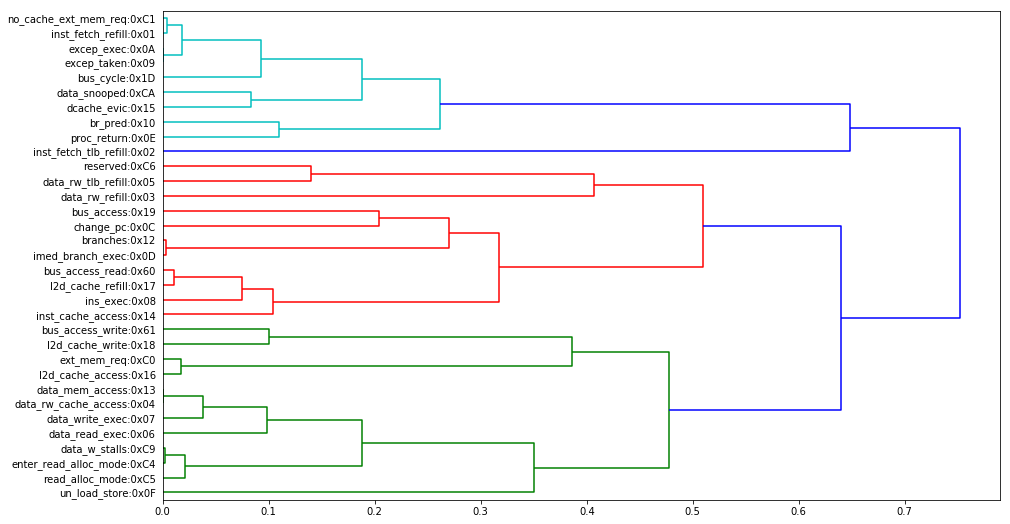

In [14]:
create_hca("/mntDrive/My Drive/Doutorado/Feature Selection/data/bots/4l.csv", FOUR_LITTLE)

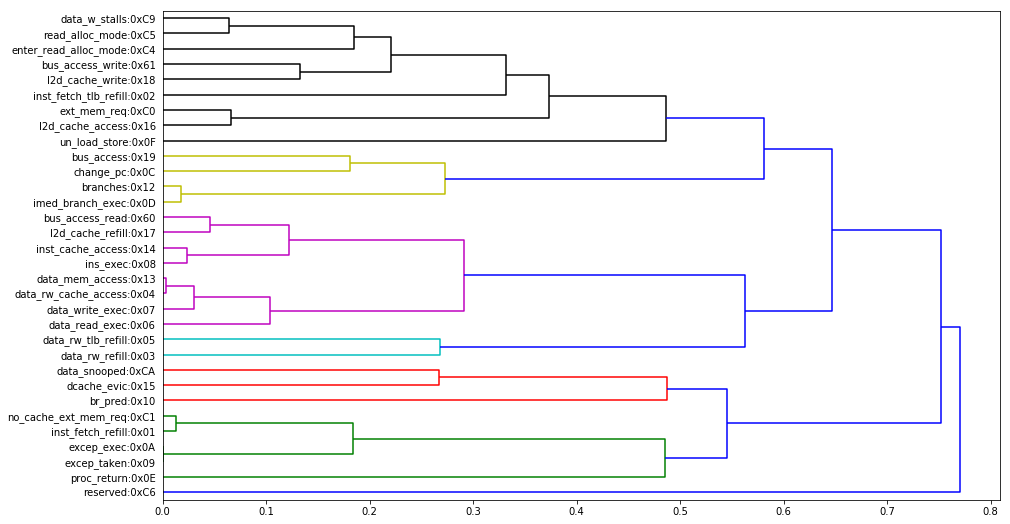

In [15]:
create_hca("/mntDrive/My Drive/Doutorado/Feature Selection/data/power/4l.csv", FOUR_LITTLE)

## HCA - 4b dataset

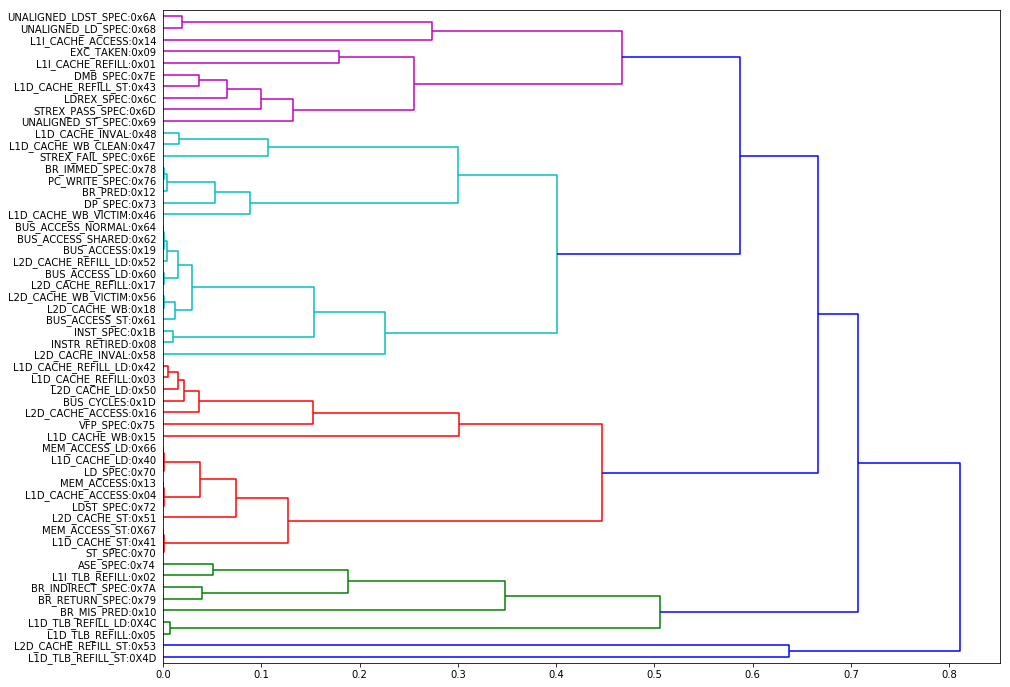

In [16]:
create_hca("/mntDrive/My Drive/Doutorado/Feature Selection/data/bots/4b.csv", FOUR_BIG)

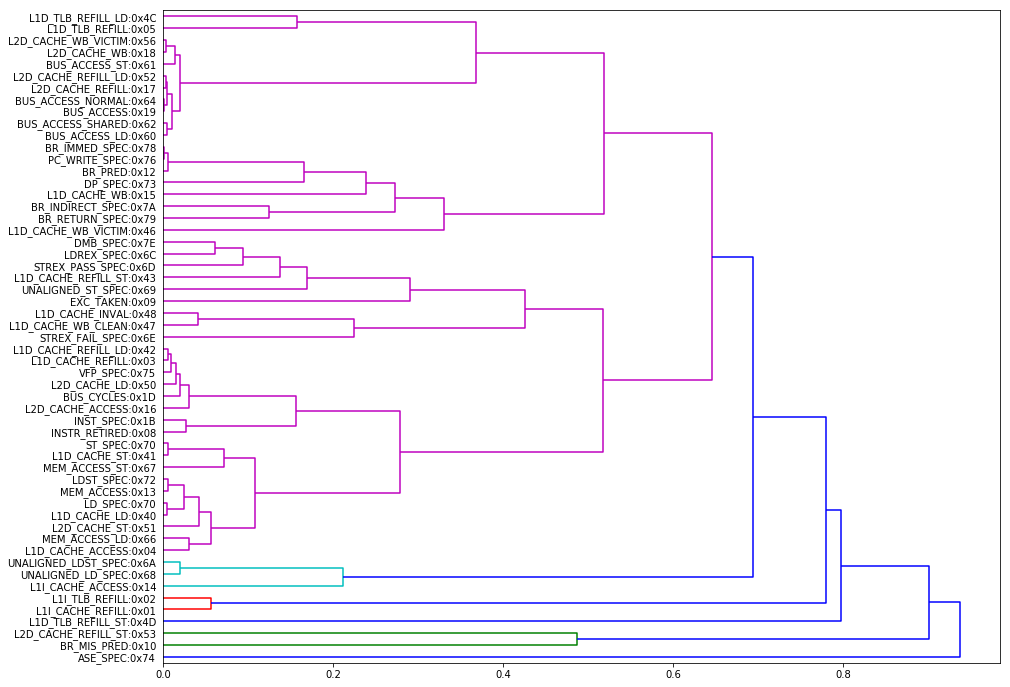

In [17]:
create_hca("/mntDrive/My Drive/Doutorado/Feature Selection/data/power/4b.csv", FOUR_BIG)

## HCA - 4b4l dataset

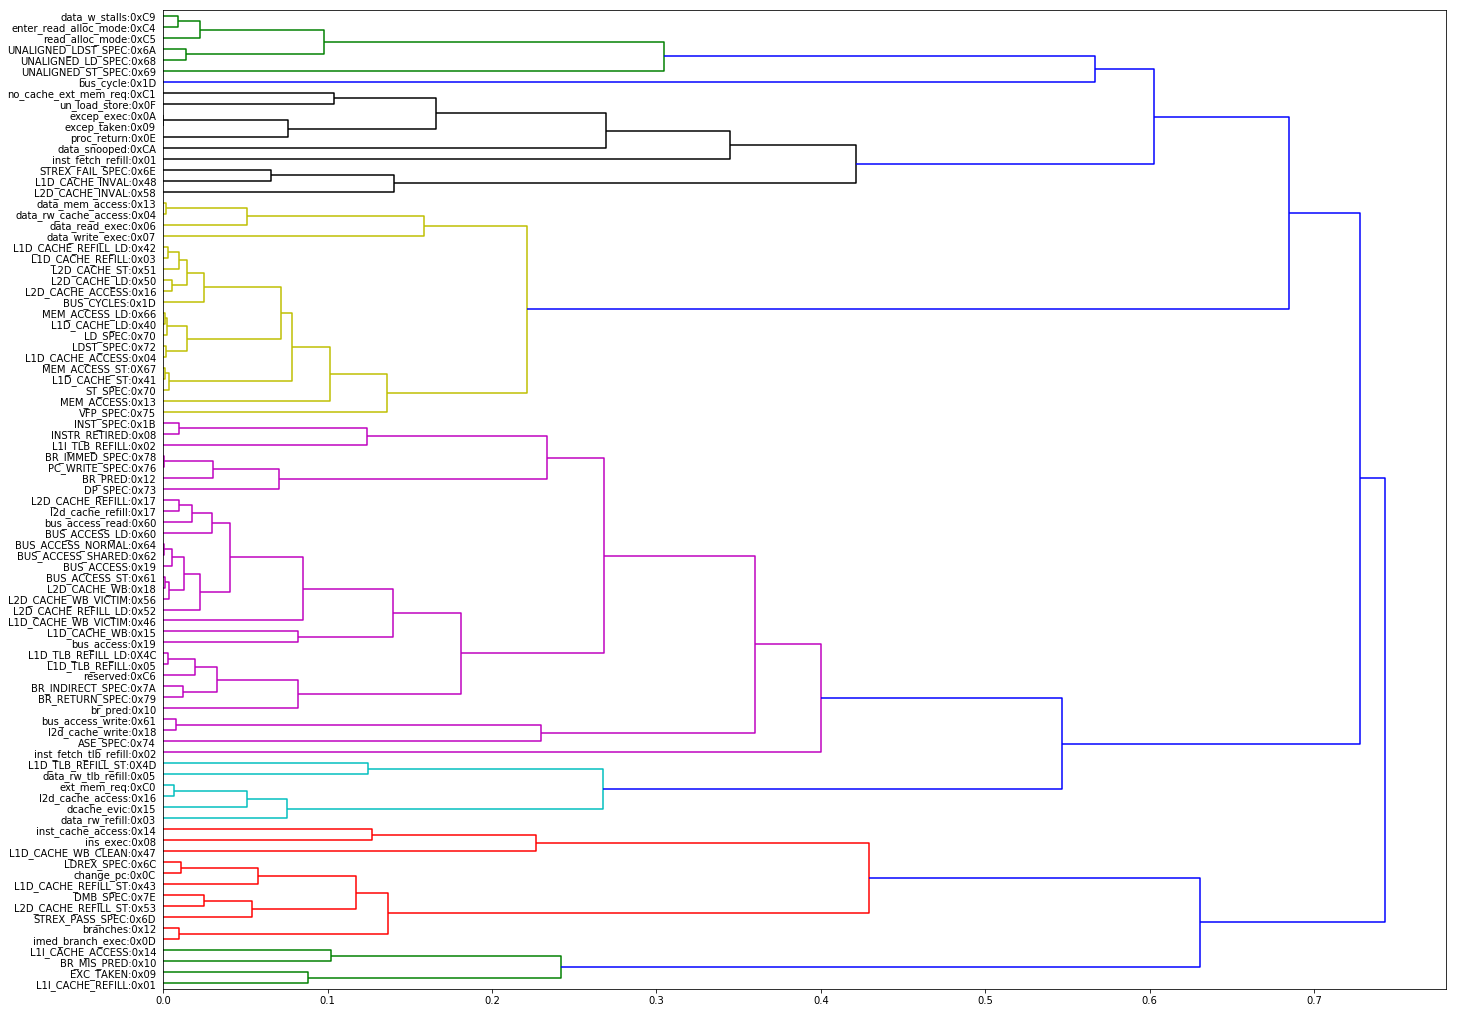

In [18]:
create_hca("/mntDrive/My Drive/Doutorado/Feature Selection/data/bots/4b4l.csv", FOUR_LITTLE_FOUR_BIG)

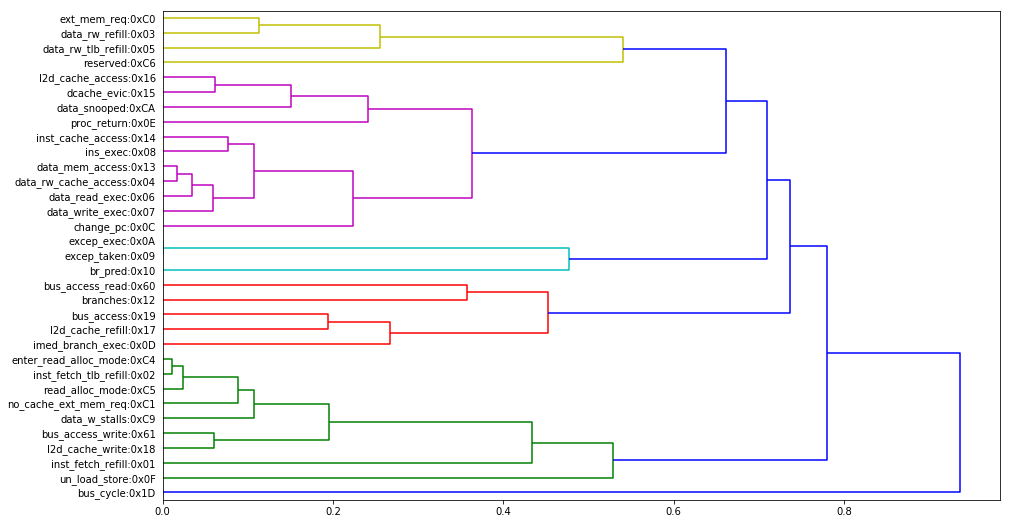

In [19]:
create_hca("/mntDrive/My Drive/Doutorado/Feature Selection/data/power/4b4l_A7.csv", FOUR_LITTLE)

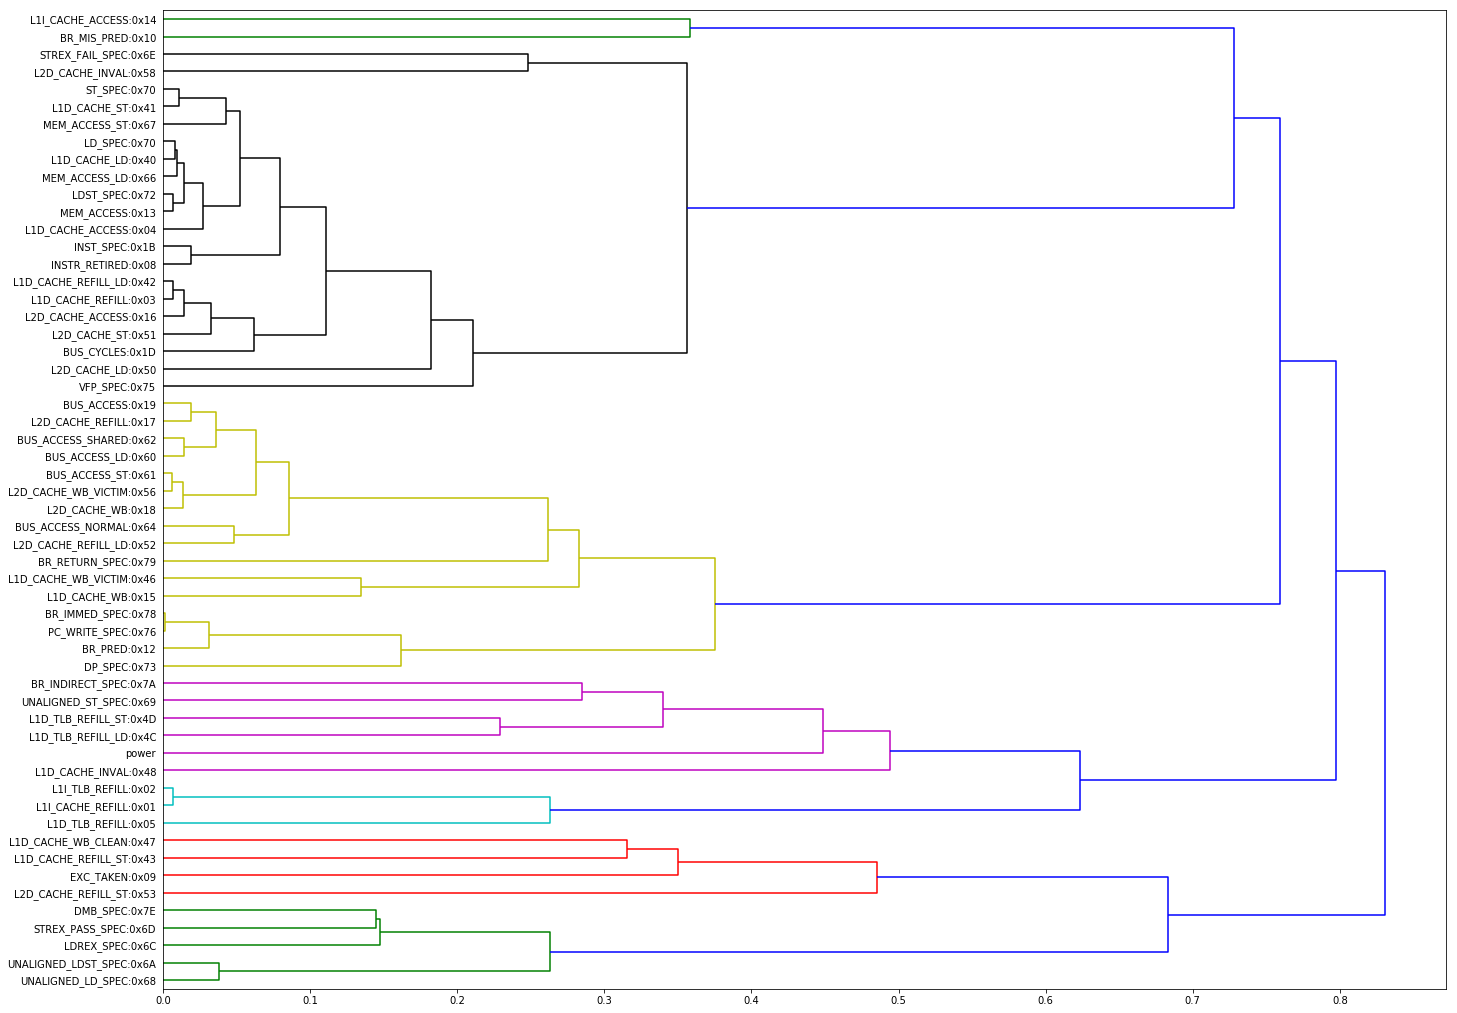

In [20]:
create_hca("/mntDrive/My Drive/Doutorado/Feature Selection/data/power/4b4l_A15.csv", FOUR_LITTLE_FOUR_BIG)

# Performance Model

## Filter Method
First we will look the 4l configuration: How to estimate execution time in other configurations(4b and 4b4l) ? Which performance counters most correlate with the target? We are going to use pearson correlation to select pmcs. We selected pmcs with correlation over 0.60.



### Analysing 4 little

First we will look the 4l configuration: How to estimate execution time in other configurations(4b and 4b4l) ? Which performance counters most correlate with the target? We are going to use pearson correlation to select pmcs. 

In [21]:
result = get_features_filter("/mntDrive/My Drive/Doutorado/Feature Selection/data/bots/4l.csv","speedup4b",0.50)
print(sorted(result.items(), key=operator.itemgetter(1),reverse=True))

[('data_snooped:0xCA', 0.7959195663709044), ('br_pred:0x10', 0.7119812371131402), ('proc_return:0x0E', 0.6952119244860157), ('dcache_evic:0x15', 0.6540862089118552), ('inst_fetch_tlb_refill:0x02', 0.6209720028209184), ('inst_fetch_refill:0x01', 0.5679693812763752), ('no_cache_ext_mem_req:0xC1', 0.5512617764200284), ('data_read_exec:0x06', 0.545906078268772), ('data_rw_refill:0x03', 0.4911353502951703), ('data_write_exec:0x07', 0.47923892489691006), ('data_mem_access:0x13', 0.4652266866143212), ('excep_taken:0x09', 0.46387412002043393), ('excep_exec:0x0A', 0.46387412002043393), ('bus_cycle:0x1D', 0.4607608828559111), ('data_rw_cache_access:0x04', 0.45816568746331526), ('imed_branch_exec:0x0D', 0.37303316740865766), ('read_alloc_mode:0xC5', 0.34383051045669305), ('branches:0x12', 0.3149420094010585), ('un_load_store:0x0F', 0.29806626582307827), ('enter_read_alloc_mode:0xC4', 0.2856656796267775), ('data_w_stalls:0xC9', 0.2628198696886324), ('ext_mem_req:0xC0', 0.2502645087747835), ('l2d_c

Since our dataset is multitarget, you need to map to each target separately. When the target is 4b, the following pmcs have been selected:

In [22]:
result = get_features_filter("/mntDrive/My Drive/Doutorado/Feature Selection/data/bots/4l.csv","speedup4b4l",0.50)
print(sorted(result.items(), key=operator.itemgetter(1),reverse=True))

[('data_snooped:0xCA', 0.7570056677990541), ('br_pred:0x10', 0.7304957214798349), ('proc_return:0x0E', 0.7220656329349835), ('dcache_evic:0x15', 0.670444171287321), ('inst_fetch_refill:0x01', 0.620510631130267), ('no_cache_ext_mem_req:0xC1', 0.6093338350857119), ('inst_fetch_tlb_refill:0x02', 0.5733977195387597), ('un_load_store:0x0F', 0.5470789538747658), ('excep_taken:0x09', 0.5109426518752), ('excep_exec:0x0A', 0.5109426518752), ('bus_cycle:0x1D', 0.4068280961183087), ('data_read_exec:0x06', 0.3444200258803783), ('imed_branch_exec:0x0D', 0.3289576695101996), ('bus_access_write:0x61', 0.3235920973375043), ('data_rw_refill:0x03', 0.29035760073682887), ('inst_cache_access:0x14', 0.2856363823979525), ('branches:0x12', 0.2673373609510479), ('change_pc:0x0C', 0.2608492359865678), ('data_rw_tlb_refill:0x05', 0.23810540221425877), ('bus_access:0x19', 0.2181988424144872), ('reserved:0xC6', 0.1852249110828572), ('data_mem_access:0x13', 0.18039782079264907), ('data_rw_cache_access:0x04', 0.171

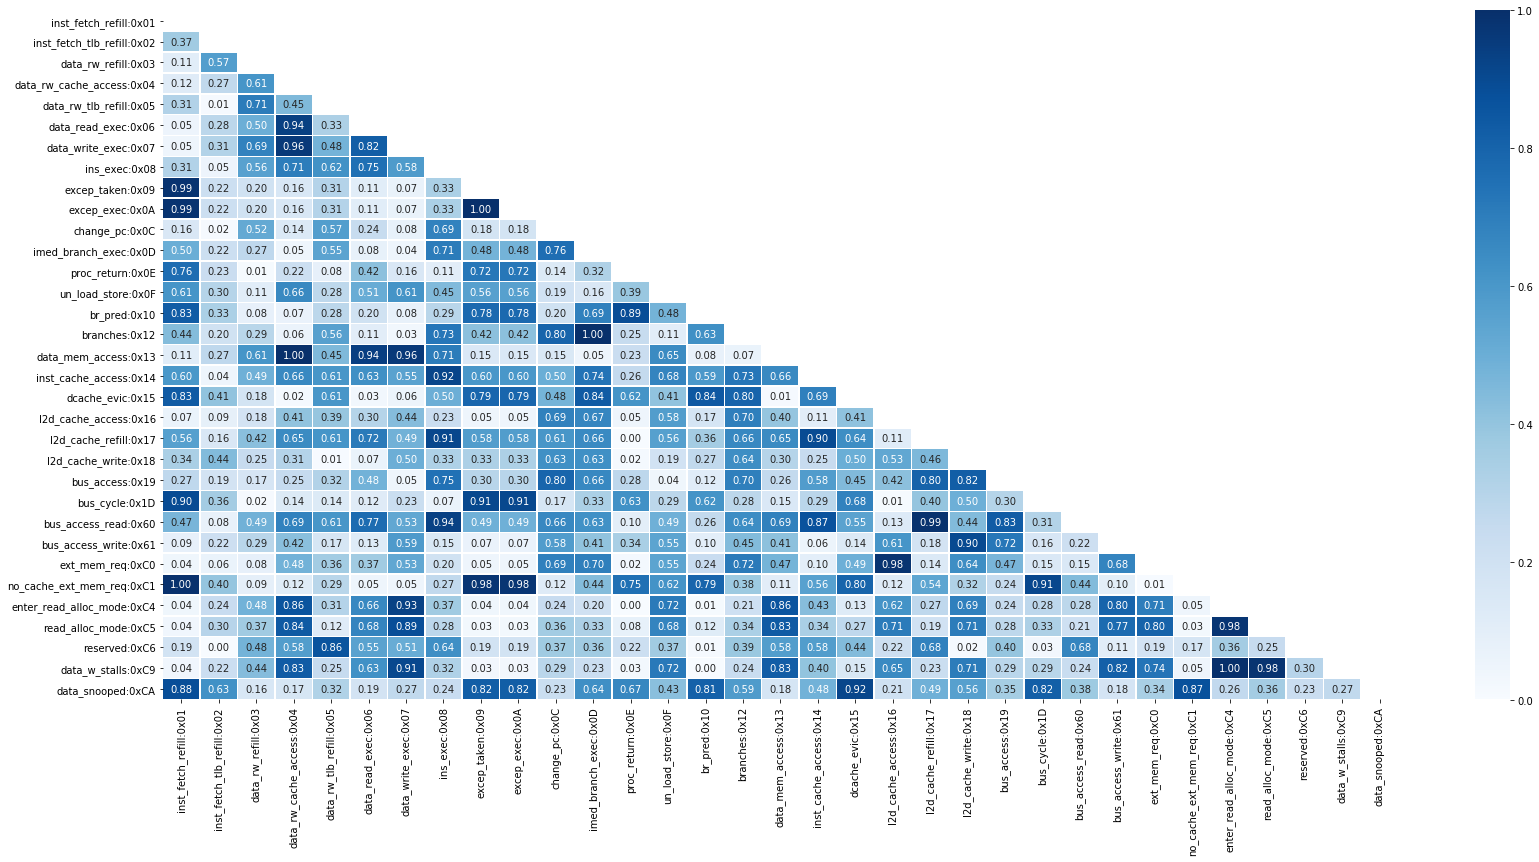

In [23]:
dictionary = get_features_filter("/mntDrive/My Drive/Doutorado/Feature Selection/data/bots/4l.csv","speedup4b4l",0.50)
plot_correlation_between_features_selected("/mntDrive/My Drive/Doutorado/Feature Selection/data/bots/4l.csv",list(dictionary.keys()),len(dictionary.keys()))

### Analysing 4b

Now analysing 4b when the target is 4l.

In [24]:
result = get_features_filter("/mntDrive/My Drive/Doutorado/Feature Selection/data/bots/4b.csv","speedup4l",0.50)
print(sorted(result.items(), key=operator.itemgetter(1),reverse=True))

[('L1D_CACHE_INVAL:0x48', 0.9532658423680135), ('L1D_CACHE_WB_CLEAN:0x47', 0.9325888251350072), ('STREX_FAIL_SPEC:0x6E', 0.9083742345540733), ('LDREX_SPEC:0x6C', 0.8346948257743523), ('DP_SPEC:0x73', 0.7585842772126771), ('L2D_CACHE_ST:0x51', 0.7532827296548391), ('L2D_CACHE_ACCESS:0x16', 0.7268047788470539), ('DMB_SPEC:0x7E', 0.7033949093297838), ('L1I_CACHE_REFILL:0x01', 0.6696358346118138), ('VFP_SPEC:0x75', 0.6513825168112081), ('L1D_CACHE_WB_VICTIM:0x46', 0.6499734994850521), ('L1D_CACHE_REFILL_LD:0x42', 0.648312247809884), ('L2D_CACHE_LD:0x50', 0.6413162220722738), ('LDST_SPEC:0x72', 0.6402029737447454), ('ST_SPEC:0x70', 0.638288132020269), ('MEM_ACCESS:0x13', 0.6334752174218512), ('L1D_CACHE_ACCESS:0x04', 0.6316883490313971), ('L1D_CACHE_ST:0x41', 0.6203274374566363), ('L1D_CACHE_REFILL_ST:0x43', 0.6168928525513151), ('MEM_ACCESS_ST:0X67', 0.6162560991355825), ('L1D_CACHE_REFILL:0x03', 0.5987470413710488), ('MEM_ACCESS_LD:0x66', 0.5925596778102259), ('L1D_CACHE_LD:0x40', 0.58673

When the target is 4b4l.

In [25]:
result = get_features_filter("/mntDrive/My Drive/Doutorado/Feature Selection/data/bots/4b.csv","speedup4b4l",0.50)
print(sorted(result.items(), key=operator.itemgetter(1),reverse=True))

[('L1D_CACHE_WB_CLEAN:0x47', 0.933712212594947), ('UNALIGNED_ST_SPEC:0x69', 0.9053099109692837), ('L1D_CACHE_INVAL:0x48', 0.8950176764323065), ('LDREX_SPEC:0x6C', 0.8842152593721541), ('DMB_SPEC:0x7E', 0.8352171633100274), ('L1D_CACHE_REFILL_ST:0x43', 0.8346401444772109), ('L1I_CACHE_REFILL:0x01', 0.834324126158118), ('VFP_SPEC:0x75', 0.82121336825958), ('STREX_PASS_SPEC:0x6D', 0.7320561881094954), ('STREX_FAIL_SPEC:0x6E', 0.7275787374420628), ('L2D_CACHE_LD:0x50', 0.70282387179968), ('L1D_CACHE_REFILL_LD:0x42', 0.6910819450387182), ('L2D_CACHE_ACCESS:0x16', 0.6456590622365941), ('L1D_CACHE_REFILL:0x03', 0.6296773801767146), ('UNALIGNED_LDST_SPEC:0x6A', 0.6181728298990177), ('BUS_CYCLES:0x1D', 0.6075166841238759), ('EXC_TAKEN:0x09', 0.6015730895929923), ('DP_SPEC:0x73', 0.5833565650729294), ('L2D_CACHE_REFILL:0x17', 0.5478226949104174), ('BUS_ACCESS_LD:0x60', 0.5403167169875853), ('L2D_CACHE_ST:0x51', 0.5266883869294753), ('BUS_ACCESS:0x19', 0.5130592434903197), ('L2D_CACHE_REFILL_ST:0

### Analysing 4b4l

Now analysing 4b4l when the target is 4l.

In [26]:
result = get_features_filter("/mntDrive/My Drive/Doutorado/Feature Selection/data/bots/4b4l.csv","speedup4l",0.50)
print(sorted(result.items(), key=operator.itemgetter(1),reverse=True))

[('dcache_evic:0x15', 0.8895561898738409), ('L1D_CACHE_INVAL:0x48', 0.8607817775791861), ('l2d_cache_access:0x16', 0.8565286652171049), ('ext_mem_req:0xC0', 0.8056062693926975), ('data_rw_cache_access:0x04', 0.7915867378181719), ('data_mem_access:0x13', 0.7864862563177162), ('STREX_FAIL_SPEC:0x6E', 0.7845775615745347), ('L1D_CACHE_WB_VICTIM:0x46', 0.768106585061643), ('data_read_exec:0x06', 0.7606190651992395), ('L1D_CACHE_WB_CLEAN:0x47', 0.7493780634152221), ('data_write_exec:0x07', 0.7116530537080373), ('bus_cycle:0x1D', 0.6998976249482958), ('L2D_CACHE_ACCESS:0x16', 0.6839794542176838), ('L2D_CACHE_LD:0x50', 0.6803189794080163), ('L2D_CACHE_ST:0x51', 0.6782883765229107), ('L1D_CACHE_ST:0x41', 0.6719314301671623), ('data_rw_refill:0x03', 0.6691764099107473), ('MEM_ACCESS_ST:0X67', 0.6620003008777795), ('ST_SPEC:0x70', 0.6616670706649886), ('L1D_CACHE_WB:0x15', 0.6531629608763706), ('VFP_SPEC:0x75', 0.6450467527132794), ('L2D_CACHE_INVAL:0x58', 0.6124615514638706), ('L1D_CACHE_REFILL:

When the target is 4b4l.

In [27]:
result = get_features_filter("/mntDrive/My Drive/Doutorado/Feature Selection/data/bots/4b4l.csv","speedup4b",0.50)
print(sorted(result.items(), key=operator.itemgetter(1),reverse=True))

[('L1D_CACHE_INVAL:0x48', 0.973687611546484), ('dcache_evic:0x15', 0.9198298652797774), ('STREX_FAIL_SPEC:0x6E', 0.9025204168756904), ('L1D_CACHE_WB_CLEAN:0x47', 0.8507658788044985), ('l2d_cache_access:0x16', 0.8310748152504056), ('L1D_CACHE_WB_VICTIM:0x46', 0.7998238257192293), ('ext_mem_req:0xC0', 0.7881299183544284), ('L2D_CACHE_INVAL:0x58', 0.7392618081272899), ('data_read_exec:0x06', 0.7375529886338754), ('data_rw_refill:0x03', 0.7272821385962965), ('L2D_CACHE_LD:0x50', 0.726509781129427), ('VFP_SPEC:0x75', 0.7207943798832717), ('data_rw_cache_access:0x04', 0.7090884482695677), ('L2D_CACHE_ACCESS:0x16', 0.7058374329000644), ('data_mem_access:0x13', 0.6919020050180651), ('L2D_CACHE_ST:0x51', 0.6796740253907027), ('EXC_TAKEN:0x09', 0.6547541035955418), ('L2D_CACHE_WB_VICTIM:0x56', 0.6399262305678817), ('L1D_CACHE_REFILL:0x03', 0.6391461566949755), ('L1I_CACHE_REFILL:0x01', 0.6370595656892791), ('L1D_CACHE_REFILL_LD:0x42', 0.636361854722077), ('L2D_CACHE_WB:0x18', 0.6225592258028189)

## Wrapper Method

### Analysing 4l


In [0]:
#plot_features_importance("/mntDrive/My Drive/Doutorado/Feature Selection/data/bots/4b.csv",FEATURE_IMPORTANCE_DTR, PERFORMANCE_TARGET)

### Analysing 4b
Since we use a model, it is possible to analyze the accuracy of the prediction first with all features and then with only the most relevant ones.

In [0]:
#plot_features_importance("/mntDrive/My Drive/Doutorado/Feature Selection/data/bots/4b.csv",FEATURE_IMPORTANCE_DTR, PERFORMANCE_TARGET)

### Analysing 4b4l
Since we use a model, it is possible to analyze the accuracy of the prediction first with all features and then with only the most relevant ones.

In [0]:
#plot_features_importance("/mntDrive/My Drive/Doutorado/Feature Selection/data/bots/4b4l.csv",FEATURE_IMPORTANCE_DTR, PERFORMANCE_TARGET)

## Selecting Features using Correlation(HCA)

### Features and HCA - Filter Method - 4l

This method is limited one target. So, we are using 4b as target. It's possible when change the target, for example to 4b4l, the performance counters order also change.

In [31]:
number_of_clusters = 4 ;
get_features_per_cluster("/mntDrive/My Drive/Doutorado/Feature Selection/data/bots/4l.csv",FOUR_LITTLE, number_of_clusters, FILTER_METHOD, PERFORMANCE_TARGET)

Erro type of model!!  0
Error! Dictionary 4l should have 33 but has only: 0


IndexError: ignored

### Features and HCA - Wrapper Method - 4l

This method is not limited one target. So, the importance each performance counters is to all configs.

In [0]:
number_of_clusters = 4 ;  
get_features_per_cluster("/mntDrive/My Drive/Doutorado/Feature Selection/data/bots/4l.csv",FOUR_LITTLE, number_of_clusters, FEATURE_IMPORTANCE_RFR, PERFORMANCE_TARGET)

### Features and HCA - Filter Method - 4b

We are using as target the 4l config.

In [0]:
number_of_clusters = 6 ;
get_features_per_cluster("/mntDrive/My Drive/Doutorado/Feature Selection/data/bots/4b.csv",FOUR_BIG, number_of_clusters, FILTER_METHOD, PERFORMANCE_TARGET)

### Features and HCA - Wrapper Method - 4b

In [0]:
number_of_clusters = 6 ; 
get_features_per_cluster("/mntDrive/My Drive/Doutorado/Feature Selection/data/bots/4b.csv",FOUR_BIG, number_of_clusters, WRAPPER_METHOD, PERFORMANCE_TARGET)

### Features and HCA - Filter Method - 4b4l

We are using as target 4b config.

In [0]:
number_of_clusters = 10 ;
get_features_per_cluster("/mntDrive/My Drive/Doutorado/Feature Selection/data/bots/4b4l.csv",FOUR_LITTLE_FOUR_BIG, number_of_clusters, FILTER_METHOD, PERFORMANCE_TARGET)

### Features and HCA - Wrapper Method - 4b4l

In [0]:
number_of_clusters = 10 ; 
get_features_per_cluster("/mntDrive/My Drive/Doutorado/Feature Selection/data/bots/4b4l.csv",FOUR_LITTLE_FOUR_BIG, number_of_clusters, WRAPPER_METHOD, PERFORMANCE_TARGET)

# Power Model

## Powmon comparison
(Figure extracted from article: Accurate and Stable Run-Time Power Modeling for Mobile and Embedded CPUs)

<img src="http://drive.google.com/uc?export=view&id=1iWjcJ_bdWfHiwAEMU8fqvwQr6wguVcgs">

As the article only shows big core performance counters, I will only show it here in this comparison.

In [32]:
select_feature_RFI("/mntDrive/My Drive/Doutorado/Feature Selection/data/power/4b.csv",FOUR_BIG, RFI_LINEAR, POWER_TARGET)

Iter: 0  PMU selected: L1D_TLB_REFILL_LD:0x4C  Score: 0.5819942856175533
Iter: 1  PMU selected: L1D_TLB_REFILL_ST:0x4D  Score: 0.7117596124198066
Iter: 2  PMU selected: EXC_TAKEN:0x09  Score: 0.7434077325619048
Iter: 3  PMU selected: DMB_SPEC:0x7E  Score: 0.7519645793320324
Iter: 4  PMU selected: L2D_CACHE_WB_VICTIM:0x56  Score: 0.7565793888271795
Iter: 5  PMU selected: LDREX_SPEC:0x6C  Score: 0.7615726997220122


In [33]:
select_feature_RFI("/mntDrive/My Drive/Doutorado/Feature Selection/data/power/4b.csv",FOUR_BIG, RFI_DTR,POWER_TARGET)

Iter: 0  PMU selected: DP_SPEC:0x73  Score: 0.9973105241581323
Iter: 1  PMU selected: INST_SPEC:0x1B  Score: 0.9987419999210295
Iter: 2  PMU selected: L1I_CACHE_ACCESS:0x14  Score: 0.9999611061466481
Iter: 3  PMU selected: L2D_CACHE_LD:0x50  Score: 0.9999884000788248
Iter: 4  PMU selected: BUS_ACCESS_SHARED:0x62  Score: 0.9999999317651695
Iter: 5  PMU selected: L1D_CACHE_ACCESS:0x04  Score: 1.0


In [39]:
select_feature_RFI("/mntDrive/My Drive/Doutorado/Feature Selection/data/power/4b.csv",FOUR_BIG, RFI_RFR,POWER_TARGET)

Iter: 0  PMU selected: MEM_ACCESS:0x13  Score: 0.9493430134795445
Iter: 1  PMU selected: STREX_PASS_SPEC:0x6D  Score: 0.9524818772813969
Iter: 2  PMU selected: L1D_CACHE_ACCESS:0x04  Score: 0.9552332116477448
Iter: 3  PMU selected: L1D_CACHE_ST:0x41  Score: 0.9557370947789826
Iter: 4  PMU selected: DP_SPEC:0x73  Score: 0.9564564424419726
Iter: 5  PMU selected: L1I_TLB_REFILL:0x02  Score: 0.9580096872128645


In [34]:
select_feature_RFE("/mntDrive/My Drive/Doutorado/Feature Selection/data/power/4b.csv",FOUR_BIG, RFE_LINEAR, POWER_TARGET)

L1D_TLB_REFILL_LD:0x4C
L1D_TLB_REFILL_ST:0x4D
L2D_CACHE_WB_VICTIM:0x56
BUS_ACCESS_LD:0x60
BUS_ACCESS_ST:0x61
BUS_ACCESS_SHARED:0x62

R2_score: 0.6943690918944436


In [35]:
select_feature_RFE("/mntDrive/My Drive/Doutorado/Feature Selection/data/power/4b.csv",FOUR_BIG, RFE_DTR, POWER_TARGET)

INSTR_RETIRED:0x08
INST_SPEC:0x1B
L1D_CACHE_WB_CLEAN:0x47
L2D_CACHE_ST:0x51
BUS_ACCESS_NORMAL:0x64
ST_SPEC:0x70

R2_score: 0.998097817631771


In [38]:
select_feature_RFE("/mntDrive/My Drive/Doutorado/Feature Selection/data/power/4b.csv",FOUR_BIG, RFE_RFR, POWER_TARGET)

INSTR_RETIRED:0x08
L2D_CACHE_ST:0x51
BUS_ACCESS_ST:0x61
PC_WRITE_SPEC:0x76
BR_IMMED_SPEC:0x78
BR_RETURN_SPEC:0x79

R2_score: 0.9507259658636283


In [36]:
dictionary = select_feature_importance("/mntDrive/My Drive/Doutorado/Feature Selection/data/power/4b.csv", FEATURE_IMPORTANCE_DTR, POWER_TARGET)
for x in list(dictionary)[0:6]:
    print (x)


L2D_CACHE_ST:0x51
INST_SPEC:0x1B
L1D_CACHE_ST:0x41
INSTR_RETIRED:0x08
L2D_CACHE_REFILL:0x17
L1D_CACHE_LD:0x40


In [37]:
dictionary = select_feature_importance("/mntDrive/My Drive/Doutorado/Feature Selection/data/power/4b.csv", FEATURE_IMPORTANCE_RFR, POWER_TARGET)
for x in list(dictionary)[0:6]:
    print (x)


BR_IMMED_SPEC:0x78
PC_WRITE_SPEC:0x76
L2D_CACHE_ST:0x51
BR_RETURN_SPEC:0x79
BUS_ACCESS_ST:0x61
L2D_CACHE_REFILL:0x17


## Others

In [0]:
import pandas as pd

path = "/mntDrive/My Drive/Doutorado/Feature Selection/data/power/4l.csv"
df = pd.read_csv(path)

df.head(8)

In [0]:
plot_features_importance("/mntDrive/My Drive/Doutorado/Feature Selection/data/power/4l.csv",FEATURE_IMPORTANCE_DTR, POWER_TARGET)

In [0]:
number_of_clusters = 4 ; 
get_features_per_cluster("/mntDrive/My Drive/Doutorado/Feature Selection/data/power/4l.csv",FOUR_LITTLE, number_of_clusters, FILTER_METHOD, POWER_TARGET)

In [0]:
number_of_clusters = 4 ; 
get_features_per_cluster("/mntDrive/My Drive/Doutorado/Feature Selection/data/power/4l.csv",FOUR_LITTLE, number_of_clusters, WRAPPER_METHOD, POWER_TARGET)

In [0]:
number_of_clusters = 4 ; 
get_features_per_cluster("/mntDrive/My Drive/Doutorado/Feature Selection/data/power/4b4l_A7.csv",FOUR_LITTLE, number_of_clusters, FILTER_METHOD, POWER_TARGET)

In [0]:
number_of_clusters = 4 ; 
get_features_per_cluster("/mntDrive/My Drive/Doutorado/Feature Selection/data/power/4b4l_A7.csv",FOUR_LITTLE, number_of_clusters, WRAPPER_METHOD, POWER_TARGET)

In [0]:
plot_features_importance("/mntDrive/My Drive/Doutorado/Feature Selection/data/power/4b.csv",POWER_TARGET)

In [0]:
get_features_filter("/mntDrive/My Drive/Doutorado/Feature Selection/data/power/4b.csv","power", 0)

In [0]:
number_of_clusters = 6 ; 
get_features_per_cluster("/mntDrive/My Drive/Doutorado/Feature Selection/data/power/4b.csv",FOUR_BIG, number_of_clusters, FILTER_METHOD, POWER_TARGET)

In [0]:
number_of_clusters = 6 ; 
get_features_per_cluster("/mntDrive/My Drive/Doutorado/Feature Selection/data/power/4b.csv", FOUR_BIG, number_of_clusters, WRAPPER_METHOD, POWER_TARGET)

In [0]:
number_of_clusters = 6 ; 
get_features_per_cluster("/mntDrive/My Drive/Doutorado/Feature Selection/data/power/4b4l_A15.csv", FOUR_BIG, number_of_clusters, WRAPPER_METHOD, POWER_TARGET) 

# Plots

## Plot switch config


In [0]:
import matplotlib.pyplot as plt
import numpy as np

num_apps = 12


configs = [["4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4b4l"],
           ["4b4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4b","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l"],
           ["4l","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b4l"],
           ["4b4l","4b","4b","4b","4b","4b4l","4b4l","4b","4b","4b","4b","4b4l","4b","4b","4b","4b4l","4b4l","4b","4b","4b4l","4b4l","4b","4b","4b4l","4b4l","4b","4b","4b4l","4b","4b","4b4l","4b4l","4b","4b","4b","4b4l","4b4l","4b","4b","4b4l","4b4l","4b","4b","4b4l","4b4l","4b","4b","4b4l","4b4l","4b","4b","4b4l","4b4l","4b","4b","4b4l","4b4l","4b","4b","4b","4b","4b4l","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b4l","4b4l","4b","4b","4b4l","4b4l","4b","4b","4b4l","4b4l","4b","4b","4b4l","4b4l","4b","4b","4b","4b4l","4b4l","4b","4b","4b4l","4b4l","4b","4b","4b4l","4b4l","4b","4b","4b4l","4b4l","4b","4b","4b4l","4b4l","4b","4b","4b4l","4b4l","4b","4b","4b4l","4b4l","4b","4b","4b4l","4b4l","4b","4b","4b4l","4b4l","4b","4b","4b4l","4b4l","4b","4b","4b4l","4b4l","4b","4b","4b4l","4b4l","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b4l","4b4l","4b","4b","4b4l","4b4l","4b","4b","4b4l","4b4l","4b","4b","4b4l","4b4l","4b","4b","4b4l","4b4l","4b","4b","4b4l","4b4l","4b","4b","4b4l","4b4l","4b","4b","4b4l","4b4l","4b","4b","4b4l","4b4l","4b","4b","4b4l","4b4l","4b","4b"],
           ["4b","4b","4l","4b4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4b","4b","4b","4l","4b","4b","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4b","4b","4b","4b","4b4l"],
           ["4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l"],
           ["4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4l","4l","4b4l","4b4l"],
           ["4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b","4l"],
           ["4l","4l","4l","4b","4b","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b4l","4b"],
           ["4b","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l","4b4l"],
           ["4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l]","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l"],
           ["4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4b4l]","4l","4l","4b4l","4b4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l"],
          ]

apps = ["fib", "nqueens", "health","floorplan","fft","sort","sparselu","strassen","backpropag", "heartwall","lavaMD","particle_filter"]

y_ticks_label = ['4l', '4b', '4b4l']

fig, axs = plt.subplots(num_apps)
#fig.suptitle('Sharing both axes')
fig.set_figheight(25)
fig.set_figwidth(15)

for i in range(num_apps):
   axs[i].plot(configs[i],linestyle='--')
   axs[i].set_yticklabels(y_ticks_label)
   axs[i].title.set_text(apps[i])
    
plt.subplots_adjust(hspace=0.5)
plt.show()

## Plot energy

## Plot Energy-delay product (EDP)

## Execution time and number of switches


In [0]:
import numpy as np
import matplotlib.pyplot as plt

apps = ['fib','nqueens','health','floorplan','fft','sort','sparselu','strassen','backprop','heartwall','lavaMD','particle_filter']
scheduler_type=['Default(4b4l)','Dynamic']

default = [88.53,89.34,31.79,65.66,104.89,23.49,54.33,29.33,54.66,28.53,62.61,51.92]
default_error = [11.19,3.41,0.22,9.04,0.61,0.61,1.06,1.04,0.47,0.31,0.08,1.61]


app_name_list=["Rodinia","Rodinia","Bots","Bots"]
method_list=["Filter","Wrapper","Filter","Wrapper"]
type_of_model_list=["Decision Tree","Decision Tree","Decision Tree","Decision Tree"]

model_list = [ [87.45,86.61,31.52,58.74,100.20,23.77,51.66,29.41,55.65,30.40,44.39,36.91],
               [86.97,87.01,31.66,40.58,94.45,23.72,52.45,30.18,55.96,29.93,43.68,37.29],   
               [43.61,34.16,20.10,36.78,43.64,23.80,53.49,29.61,63.46,29.82,62.79,51.65],
               [40.41,34.19,20.15,37.27,45.11,23.69,55.72,29.67,57.33,29.71,55.25,53.59]
             ]

model_error_list = [ [34.87,3.74,0.39,30.85,38.91,0.37,1.10,1.18,1.35,0.74,3.43,1.10],
                     [34.87,3.00,0.47,19.62,52.47,0.51,2.35,4.92,1.23,0.73,1.41,1.20],
                     [30.26,1.39,0.22,5.94,0.43,0.43,0.59,1.12,1.47,0.98,0.14,1.16],
                     [1.88,1.04,0.16,4.31,1.92,0.53,2.76,1.04,2.31,1.04,1.02,4.68]
                   ]

number_switch_list = [ [0.30,0.00,0.00,8.70,0.10,0.00,0.00,1.20,1.00,9.80,1.40,1.80],
                       [0.50,0.00,0.00,1.00,0.30,0.00,0.00,0.30,1.30,11.70,1.00,1.00],
                       [144.90,38.50,1.60,1.00,54.80,0.00,0.00,0.00,2.00,0.00,0.00,0.00],
                       [95.10,4.40,1.00,1.00,1.50,0.00,11.50,1.50,7.70,0.00,1.10,192.40]
                     ]


for i in range(len(app_name_list)):
    app_name=app_name_list[i]
    method=method_list[i]
    type_of_model=type_of_model_list[i]

    model = model_list[i]
    model_error = model_error_list[i]
    number_switch = number_switch_list[i]


    perc=[]
    for i in range(len(apps)):       
      temp = (1 - (model[i]/default[i]))
      perc.append(temp)


    fig = plt.gcf()
    fig.set_size_inches(11, 6) #size of plot
    x_pos = np.arange(len(apps))

    #PLOT DO GRÁFICO 1
    ax = plt.subplot(2, 1, 1)
    ax.set_ylabel('Percentage Improvement (%)')
    ax.bar(x_pos, perc, width=0.4, color='g',tick_label=apps,capsize=3)
    ax.spines['top'].set_position('zero')#remove line top
    ax.spines['bottom'].set_position('zero')#remove line bottom
    plt.xticks(rotation=90)


    #PLOT DO GRÁFICO 2
    title_name = "Execution Time for Static(4b4l) vs Dynamic" + "\nSelect Feature - "+str(method) + "Method " + "\nModel - " + str(type_of_model)+ " based on " + str(app_name) 
    plt.title(title_name,fontsize=12)
    ax = plt.subplot(2, 1, 2)
    ax.set_ylabel('Execution Time (seconds) \n 95 CI for the Mean%')
    ax.bar(x_pos, default, yerr=default_error, width=0.4, color='b',capsize=3,label="Defaul(4b4l)")
    bar_plot = ax.bar(x_pos+0.4, model, yerr=model_error, width=0.4, color='g',tick_label=apps,capsize=3, label="Dynamic")
    ax.spines['top'].set_position('zero') #remove top lines
    plt.xticks(rotation=90)
    plt.legend()

    plt.gcf().subplots_adjust(bottom=0.25)#position image inside plot
    plt.subplots_adjust(hspace=2.0)#distance between subplot
    ax.legend(bbox_to_anchor=(1.0, 1.55))#legend position 

    #ADIÇÃO DE NÚMEROS NO TOPO DO BAR PLOT
    i=0
    for idx,rect in enumerate(bar_plot):
       height = rect.get_height()
       ax.text(rect.get_x() + rect.get_width()/2., 1.17*height, '%d' % int(number_switch[i]), ha='center', va='bottom', rotation=0)
       i = i+1

    #ADIÇÃO DE TEXTO E SETAS NO PLOT
    plt.annotate("number of\n switch ", xy=(10.1, 75),xytext=(5, 163), arrowprops=dict(arrowstyle='-|>', fc="k", ec="k", lw=1.0),size=8)
    plt.annotate("number of\n switch ", xy=(5.4, 107),xytext=(5, 163), arrowprops=dict(arrowstyle='-|>', fc="k", ec="k", lw=1.0),size=8)
    plt.annotate("number of\n switch ", xy=(1.7, 105),xytext=(5, 163), arrowprops=dict(arrowstyle='-|>', fc="k", ec="k", lw=1.0),size=8)

    file_name="model_" + app_name + "_" + method + ".png"
    #plt.savefig(file_name)
    plt.show()
    plt.clf() # clear the current figure
    plt.cla() # clear the current axes
